# Enet using deconvo genes from Bayes Prism (mirroring feature engineering as closely as possible to original paper)

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
import pickle

## Data Filtering

In [2]:
# import data
ann_tcga = pd.read_csv('../data/toga.breast.brca.status.txt', sep='\t', index_col=0)
tcga_brca = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
deconvo = pd.read_csv('../data/Deconvo2.csv',  index_col=0)
hrd_scores = pd.read_excel('../data/tcga.hrdscore.xlsx')

In [3]:
# ann_tcga[ann_tcga['event.PALB2'].ne('0')]
# ann_tcga[ann_tcga['event.RAD51C'].ne('0')]
ann_tcga = ann_tcga[~ann_tcga['event.RAD51C'].ne('0')]
ann_tcga = ann_tcga[~ann_tcga['event.PALB2'].ne('0')]
ann_tcga = ann_tcga[ann_tcga['event.BRCA1'] != '1']

In [4]:
ann_tcga.index = ann_tcga.index.str.replace('.', '-', regex=False)
tcga_brca = tcga_brca.set_index('Case ID')
tcga_brca = tcga_brca[tcga_brca['Sample Type'] == 'Primary Tumor']
print(f"annotated shape{ann_tcga.shape}")
print(f"rna-seq shape{tcga_brca.shape}")

annotated shape(962, 33)
rna-seq shape(1111, 60662)


In [5]:
common_indices = ann_tcga.index.intersection(tcga_brca.index)

# Filter DataFrames to keep only rows with common indices
ann_tcga = ann_tcga.loc[common_indices]
tcga_brca = tcga_brca.loc[common_indices]
print(f"rna-seq shape{tcga_brca.shape}")

rna-seq shape(960, 60662)


In [6]:
deconvo.index = deconvo.index.map(lambda x: x[:12])

In [7]:
common_indices1 = deconvo.index.intersection(tcga_brca.index)
tcga_brca.loc[common_indices1].shape

(835, 60662)

In [8]:
# tcga_brca.loc[tcga_brca.index.difference(deconvo.index)]
# deconvo.loc[deconvo.index.difference(tcga_brca.index)]

In [9]:
hrd_scores = hrd_scores.set_index('sample')

hrd_scores = hrd_scores.loc[hrd_scores.index.intersection(deconvo.index)]
labels_df = hrd_scores['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR-Proficient')
labels_df = labels_df.sort_index()
deconvo = deconvo.sort_index()
deconvo = np.log2(deconvo + 1)

In [10]:
labels = labels_df.squeeze()
features_df = deconvo

In [16]:
deconvo

,NOC2L,PLEKHN1,HES4,ISG15,AGRN,RNF223,C1orf159,TNFRSF18,SDF4,B3GALT6,...,COL6A2,SPATC1L,LSS,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
TCGA-3C-AAAU,12.776388,9.525255,7.775972,9.632014,13.804956,9.065023,10.188267,10.737410,13.070355,10.765830,...,12.014143,9.814159,12.218344,12.250889,8.461905,10.477127,12.274172,11.695782,4.635058,12.288344
TCGA-3C-AALI,10.869023,7.230856,8.386983,9.631483,11.478919,5.576159,8.056930,7.616181,11.174601,8.760208,...,12.293407,8.154028,11.084311,10.021530,7.250999,9.207600,9.812954,10.591780,6.330845,11.009456
TCGA-3C-AALJ,11.129278,7.316978,7.935743,8.081190,12.121631,8.433928,8.945713,8.361453,10.720385,9.489952,...,11.428159,0.706641,8.665080,8.385621,6.772466,8.140840,8.703364,9.253186,6.305606,9.795105
TCGA-3C-AALK,11.862520,9.746870,9.424922,9.731604,13.675871,9.481590,9.838101,9.323118,12.118759,9.985557,...,12.865906,8.270417,10.850559,9.936491,7.844863,8.793740,10.196400,10.439931,7.056107,11.554115
TCGA-4H-AAAK,11.501369,8.197571,7.238443,9.436470,13.030306,6.569066,8.949395,8.377158,11.400632,9.234406,...,12.026503,8.434511,10.280678,10.045618,7.931565,7.973129,10.079815,9.596816,6.606798,10.962922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-W8-A86G,11.633339,9.578305,8.962260,8.581216,13.761686,6.276571,10.426382,8.859498,12.248557,10.433260,...,12.441353,8.092863,11.211820,10.560906,8.231490,9.640744,10.682819,10.980925,10.289507,12.111633
TCGA-WT-AB41,9.821799,4.090853,7.199437,11.535034,10.790518,6.968275,8.526883,8.275231,10.632864,9.183139,...,11.336357,7.392524,9.721229,6.346602,9.759309,7.318895,8.675632,7.789599,8.057277,9.932982
TCGA-XX-A89A,10.303749,6.218704,5.999008,7.561479,11.059923,5.402722,8.353200,7.437794,10.909695,8.407710,...,11.787885,7.771489,10.248867,10.401707,7.485620,7.882741,10.471915,9.920746,9.593660,10.816235
TCGA-Z7-A8R5,10.826145,8.073456,8.741494,8.536162,11.624223,6.345467,8.868563,7.812524,11.438307,10.139592,...,11.345022,8.563356,10.012233,8.291622,8.750553,6.502458,9.379751,8.782749,11.101816,11.385744


## Regression: Takes 250 hrs 6-cpu

In [17]:
# Initialize a list to store coefficients from each iteration
coefficients_list = []

# Split the data into training and test sets (1/3 test split)
X_train, X_test, y_train, y_test = train_test_split(
    features_df, labels, test_size=1/3, stratify=labels, random_state=123
)

# Run 1000 iterations
for iteration in range(10):
    print(f"Iteration {iteration + 1} of 1000")
    
    # Define the LogisticRegressionCV model
    logreg_cv = LogisticRegressionCV(
        Cs=10,  # Number of Cs to try; you can specify an array of Cs if desired
        cv=10,  # Tenfold cross-validation
        penalty='elasticnet',
        solver='saga',  # Solver that supports elastic net penalty
        # multi_class='multinomial',
        l1_ratios=[0.25],  # Alpha = 0.25
        max_iter=1000,
        n_jobs=-1,  # Utilize all processors
        random_state=123*iteration
    )
    
    # Fit the model
    logreg_cv.fit(X_train, y_train)
    
    # Get coefficients at the best C (lambda.min)
    coef = logreg_cv.coef_  # Shape: (n_classes, n_features)
    
    # Append the coefficients to the list
    coefficients_list.append(coef)


with open('../data/output/reg_coefs_list.pkl', 'wb') as f:
    pickle.dump(coefficients_list, f)


Iteration 1 of 1000


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 2 of 1000


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 3 of 1000


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 4 of 1000


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 5 of 1000


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 6 of 1000


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 7 of 1000


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 8 of 1000


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 9 of 1000


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 10 of 1000


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [18]:
# If not running reg:
with open('../data/output/reg_coefs_list.pkl', 'rb') as f:
    coefficients_list = pickle.load(f)
coefficients_list

[array([[ 0.00362679, -0.01354398, -0.01611363, ..., -0.00555848,
         -0.00512271, -0.00010848]]),
 array([[ 0.00362646, -0.01354519, -0.01611853, ..., -0.00555913,
         -0.00511774, -0.00010928]]),
 array([[ 0.00362583, -0.01354933, -0.01611934, ..., -0.00555781,
         -0.00511841, -0.00010737]]),
 array([[ 0.00362623, -0.01354371, -0.0161172 , ..., -0.00555942,
         -0.00511909, -0.00010975]]),
 array([[ 0.00362601, -0.01354685, -0.01612149, ..., -0.0055571 ,
         -0.00512083, -0.00010758]]),
 array([[ 0.00362588, -0.01354824, -0.01611785, ..., -0.00555763,
         -0.00511397, -0.00010697]]),
 array([[ 0.00362509, -0.01355027, -0.01611945, ..., -0.00556022,
         -0.00511738, -0.00010922]]),
 array([[ 0.00362725, -0.01354659, -0.01611996, ..., -0.00556054,
         -0.00512105, -0.00010921]]),
 array([[ 0.0036261 , -0.01354401, -0.01612503, ..., -0.00555925,
         -0.00511741, -0.00011041]]),
 array([[ 0.00362574, -0.01354538, -0.01611461, ..., -0.00556167

In [19]:
# Step 1: Identify genes with non-zero coefficients across all iterations
coefficients_array = np.array(coefficients_list)  # Shape: (1000, n_classes, n_features)
non_zero_coefficients = np.any(coefficients_array != 0, axis=1)  # Shape: (1000, n_features)
non_zero_counts = np.sum(non_zero_coefficients, axis=0)  # Shape: (n_features,)
genes_selected_mask = non_zero_counts == len(coefficients_list)
selected_gene_indices = np.where(genes_selected_mask)[0]
feature_names = features_df.columns
selected_genes = feature_names[selected_gene_indices]

print(f"Number of selected genes: {len(selected_genes)}") 


Number of selected genes: 9478


In [20]:
non_zero_counts

array([10, 10, 10, ..., 10, 10, 10])

In [21]:
# Step 2: Compute centroids for each class
features_selected = features_df[selected_genes]
labels_aligned = labels.loc[features_selected.index]
centroids = features_selected.groupby(labels_aligned).mean()

In [22]:
# Step 3: Define function to calculate scores for new samples
from scipy.stats import pearsonr

def calculate_scores(new_sample):
    new_sample_selected = new_sample[selected_genes]
    scores = {}
    for class_label in centroids.index:
        centroid = centroids.loc[class_label]
        corr_coef, _ = pearsonr(new_sample_selected, centroid)
        scores[class_label] = corr_coef
    return scores

# Example usage with a new sample
# new_sample = pd.Series(..., index=selected_genes)

# Calculate scores
# scores = calculate_scores(new_sample)
# print(scores)


In [27]:
first_sample = deconvo.iloc[1]
new_sample = pd.Series(first_sample.values, index=deconvo.columns)
scores = calculate_scores(new_sample)
print(scores)

{'HR-Proficient': 0.8740248710881784, 'HRD': 0.8690705318235861}


In [25]:
logreg_cv.score(X_test, y_test)

0.8585209003215434

In [26]:
from sklearn.metrics import classification_report

y_pred = logreg_cv.predict(X_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

HR-Proficient       0.89      0.93      0.91       237
          HRD       0.73      0.64      0.68        74

     accuracy                           0.86       311
    macro avg       0.81      0.78      0.80       311
 weighted avg       0.85      0.86      0.85       311



In [43]:
y_pred = logreg_cv.predict(deconvo.iloc[[731]])
y_pred

array(['HRD'], dtype=object)

In [42]:
hrd_scores.iloc[731]

HRD             15
Telomeric AI    19
LST             12
HRD-sum         46
Name: TCGA-E2-A1LE, dtype: int64

FFAR2      0.077128
LRP2       0.076168
NPY1R      0.074679
AREG       0.071611
FAM3B      0.063057
             ...   
DPH6       0.000000
MAPKBP1    0.000000
ZNF106     0.000000
SENP6      0.000000
RDX        0.000000
Name: Coefficient, Length: 9853, dtype: float64


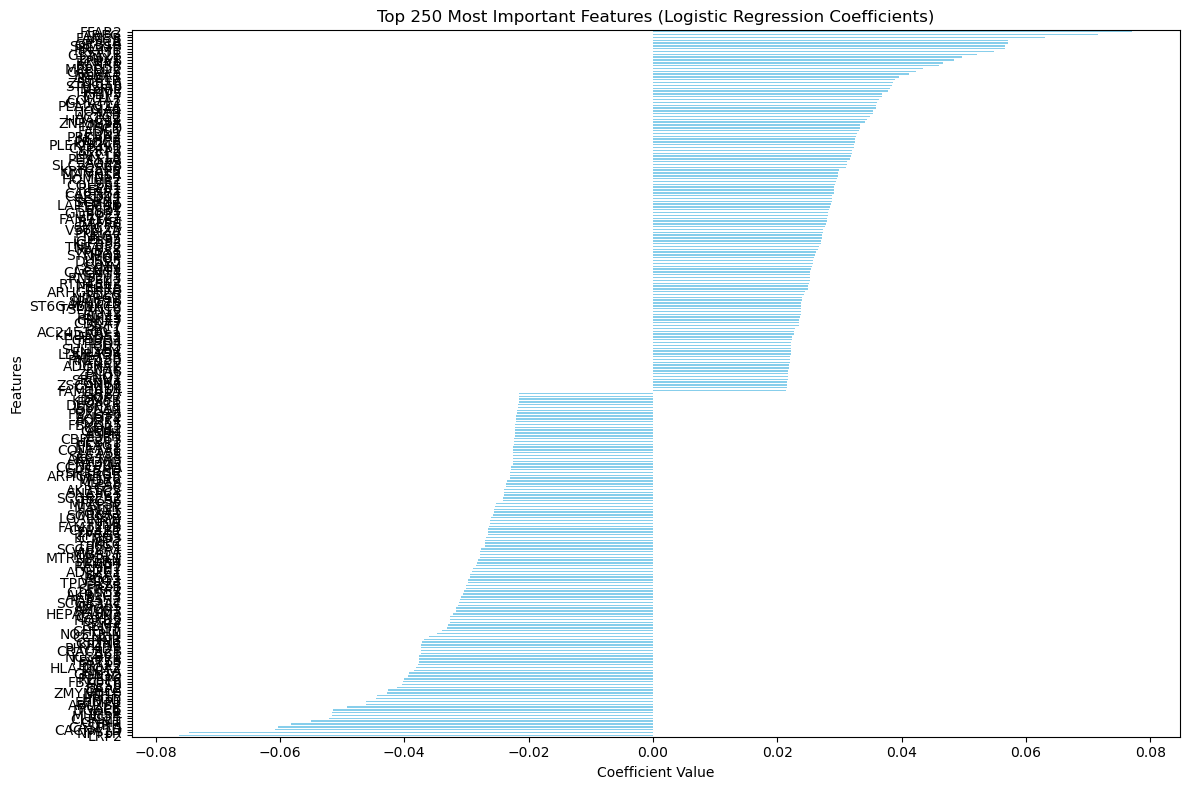

In [50]:
queefs = logreg_cv.coef_

# Assuming X_train is a DataFrame
feature_names = X_train.columns
queefs_df = pd.DataFrame(queefs[0], index=feature_names, columns=["Coefficient"])
important_features = queefs_df["Coefficient"].abs().sort_values(ascending=False)
print(important_features)
# import matplotlib.pyplot as plt

# important_features.plot(kind='bar', figsize=(10, 6))
# plt.title("Feature Importance (Logistic Regression queefs)")
# plt.ylabel("Coefficient Magnitude")
# plt.show()

import matplotlib.pyplot as plt

# Sort by absolute coefficient value and select the top 250
top_features = queefs_df["Coefficient"].abs().nlargest(250)
top_features = queefs_df.loc[top_features.index]

# Plot the top 250 features
plt.figure(figsize=(12, 8))
top_features["Coefficient"].sort_values().plot(kind="barh", color="skyblue")
plt.title("Top 250 Most Important Features (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [75]:
x = 'CRACR2B'

In [76]:
queefs_df.loc[x]

Coefficient   -0.037318
Name: CRACR2B, dtype: float64

In [77]:
top_features.loc[x]

Coefficient   -0.037318
Name: CRACR2B, dtype: float64

In [78]:
ugh = ['MXRA8',
'PRKCZ',
'MEGF6',
'FBXO2',
'UBXN10',
'SYTL1',
'CITED4',
'C1orf210',
'GPX7',
'GBP4',
'VAV3',
'MLLT11',
'ATP1A4',
'KLHDC9',
'RABGAP1L',
'FMOD',
'RAB29',
'ZBTB18',
'SH3YL1',
'ATP6V1E2',
'UBE2E3',
'FRZB',
'PPIL3',
'PECR',
'TMEM198',
'STK11IP',
'IRS1',
'KIF1A',
'NUP210',
'ALS2CL',
'IP6K2',
'DALRD3',
'APEH',
'CACNA1D',
'FHIT',
'MTRNR2L12',
'COPG1',
'DHX36',
'USP13',
'MAGEF1',
'SENP2',
'ZNF718',
'AREG',
'SLC7A11',
'MAP9',
'SORBS2',
'FRG1',
'NADK2',
'FAM174A',
'DTWD2',
'PCDHB4',
'PCDH1',
'THOC3',
'SIMC1',
'F12',
'FAM135A',
'OGFRL1',
'CD109',
'RRAGD',
'WASF1',
'ACAT2',
'SNX10',
'SCRN1',
'NCF1',
'TMEM120A',
'AZGP1',
'SMKR1',
'PODXL',
'AKR1B1',
'TMEM139',
'SPIDR',
'TPD52',
'CA13',
'ATP6V1C1',
'BAALC',
'AARD',
'EXT1',
'SAMD12',
'MAL2',
'TAF2',
'MTBP',
'ZHX1',
'FBXO32',
'SQLE',
'LRRC6',
'VLDLR',
'SIGMAR1',
'ALDH1B1',
'CKS2',
'SYK',
'PHYHD1',
'PTGES',
'BET1L',
'RIC8A',
'SIRT3',
'RNH1',
'LRRC56',
'IRF7',
'PNPLA2',
'CRACR2B',
'ASCL2',
'TSSC4',
'PPFIBP2',
'CTR9',
'CD44',
'TCN1',
'FADS2',
'ME3',
'DCUN1D5',
'CLMP',
'SPA17',
'TMEM218',
'FOXRED1',
'GLB1L2',
'ANKRD30A',
'PDCD4',
'TACC2',
'TEAD4',
'LAG3',
'ZNF605',
'ZNF10',
'BRCA2',
'N4BP2L2',
'EXOSC8',
'COG3',
'PHF11',
'EBPL',
'IPO5',
'TEX30',
'IRS2',
'CARS2',
'ING1',
'TFDP1',
'GSC',
'SLC25A29',
'JAG2',
'RASL12',
'LARP6',
'ZNF592',
'AEN',
'ACAN',
'HAPLN3',
'MFGE8',
'FANCI',
'POLG',
'ANPEP',
'ARPIN',
'GDPGP1',
'NGRN',
'HDDC3',
'UNC45A',
'RCCD1',
'PRC1',
'ASB7',
'SNRPA1',
'IL32',
'BOLA2B',
'IRX6',
'MT1G',
'PLEKHG4',
'C16orf95',
'GALNS',
'CBFA2T3',
'CPNE7',
'YWHAE',
'INPP5K',
'GABARAP',
'KDM6B',
'ZSWIM7',
'TTC19',
'LYRM9',
'UNC119',
'NEK8',
'TRAF4',
'PGAP3',
'JUP',
'ACLY',
'NKIRAS2',
'BRCA1',
'TMUB2',
'EFTUD2',
'FMNL1',
'PRR15L',
'DCAF7',
'TACO1',
'LRRC37A3',
'SLC39A11',
'ARMC7',
'MIF4GD',
'WBP2',
'EVPL',
'SEC14L1',
'TK1',
'SOCS3',
'CANT1',
'CARD14',
'RPTOR',
'ALYREF',
'FOXK2',
'FN3KRP',
'FN3K',
'TMEM241',
'MOCOS',
'NFATC1',
'C20orf96',
'RBCK1',
'FAM110A',
'SLC4A11',
'DZANK1',
'CD40',
'SLC25A23',
'LRRC8E',
'FXYD5',
'SYNE4',
'BCKDHA',
'CNFN',
'CXCL17',
'PVR',
'ZNF583',
'ZNF419',
'TMEM191B',
'TOP3B',
'PRAME',
'PLA2G6',
'NPTXR',
'ODF3B',
'PCP4',
'RSPH1']
pp_count = 0
for i in ugh:
    if i in top_features.index:
        pp_count+=1
pp_count

21

In [81]:
pp_count = 0
for i in ugh:
    if i in queefs_df.index:
        pp_count+=1
pp_count

228

In [83]:
for i in ugh:
    print(calculate_scores(deconvo.loc[i]))

KeyError: 'MXRA8'

In [84]:
deconvo

,NOC2L,PLEKHN1,HES4,ISG15,AGRN,RNF223,C1orf159,TNFRSF18,SDF4,B3GALT6,...,COL6A2,SPATC1L,LSS,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
TCGA-3C-AAAU,12.776388,9.525255,7.775972,9.632014,13.804956,9.065023,10.188267,10.737410,13.070355,10.765830,...,12.014143,9.814159,12.218344,12.250889,8.461905,10.477127,12.274172,11.695782,4.635058,12.288344
TCGA-3C-AALI,10.869023,7.230856,8.386983,9.631483,11.478919,5.576159,8.056930,7.616181,11.174601,8.760208,...,12.293407,8.154028,11.084311,10.021530,7.250999,9.207600,9.812954,10.591780,6.330845,11.009456
TCGA-3C-AALJ,11.129278,7.316978,7.935743,8.081190,12.121631,8.433928,8.945713,8.361453,10.720385,9.489952,...,11.428159,0.706641,8.665080,8.385621,6.772466,8.140840,8.703364,9.253186,6.305606,9.795105
TCGA-3C-AALK,11.862520,9.746870,9.424922,9.731604,13.675871,9.481590,9.838101,9.323118,12.118759,9.985557,...,12.865906,8.270417,10.850559,9.936491,7.844863,8.793740,10.196400,10.439931,7.056107,11.554115
TCGA-4H-AAAK,11.501369,8.197571,7.238443,9.436470,13.030306,6.569066,8.949395,8.377158,11.400632,9.234406,...,12.026503,8.434511,10.280678,10.045618,7.931565,7.973129,10.079815,9.596816,6.606798,10.962922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-W8-A86G,11.633339,9.578305,8.962260,8.581216,13.761686,6.276571,10.426382,8.859498,12.248557,10.433260,...,12.441353,8.092863,11.211820,10.560906,8.231490,9.640744,10.682819,10.980925,10.289507,12.111633
TCGA-WT-AB41,9.821799,4.090853,7.199437,11.535034,10.790518,6.968275,8.526883,8.275231,10.632864,9.183139,...,11.336357,7.392524,9.721229,6.346602,9.759309,7.318895,8.675632,7.789599,8.057277,9.932982
TCGA-XX-A89A,10.303749,6.218704,5.999008,7.561479,11.059923,5.402722,8.353200,7.437794,10.909695,8.407710,...,11.787885,7.771489,10.248867,10.401707,7.485620,7.882741,10.471915,9.920746,9.593660,10.816235
TCGA-Z7-A8R5,10.826145,8.073456,8.741494,8.536162,11.624223,6.345467,8.868563,7.812524,11.438307,10.139592,...,11.345022,8.563356,10.012233,8.291622,8.750553,6.502458,9.379751,8.782749,11.101816,11.385744
